In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import DOMWidget, widget_serialization
from matplotlib import is_interactive, rcParams
from matplotlib._pylab_helpers import Gcf
from matplotlib.backend_bases import NavigationToolbar2, _Backend, cursors
from matplotlib.backends.backend_webagg_core import (
    FigureCanvasWebAggCore,
    FigureManagerWebAgg,
    NavigationToolbar2WebAgg,
    TimerTornado,
)
%matplotlib
import ipympl



Using matplotlib backend: module://matplotlib_inline.backend_inline


In [1]:
import numpy as np
from scipy.signal import windows
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

/home/murray/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


CSV file 'sweep.csv' generated successfully!


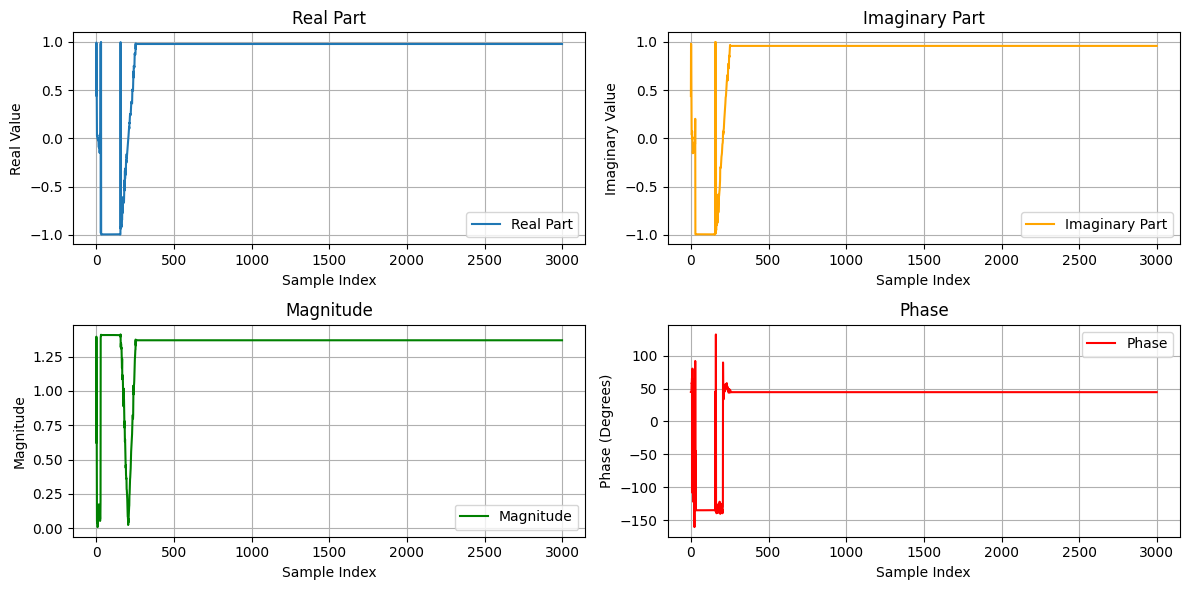

3000


In [12]:


# Define the path to your binary file
file_path = 'loopback_from_file_test.bin'


# Read the binary file
with open(file_path, 'rb') as file:
    # Read the data into a numpy array
    # The dtype should match the type of data in the file (double = float64)
    data = np.fromfile(file, dtype=np.float64)

# Reshape or process the data if needed
# Here we assume data was written as 2 doubles per sample
num_new_samples = int(len(data)/2)
data = data.reshape((num_new_samples, 2))
#data = data[30000:32000]


# Create complex numbers from the real and imaginary parts
complex_data = data[:, 0] + 1j * data[:, 1]

fs = 25e6
fft_data = np.fft.fftshift(np.fft.fft(complex_data))
fft_freq_axis = np.fft.fftfreq(len(fft_data),1/fs)

# Compute magnitude and phase
magnitudes = np.abs(complex_data)
phases = np.angle(complex_data, deg=True)  # Phase in degrees

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot real part
real = np.real(complex_data)
#real = moving_average_filter(real,10)
axs[0, 0].plot(real, label='Real Part')
axs[0, 0].set_title('Real Part')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Real Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot imaginary part
axs[0, 1].plot(np.imag(complex_data), label='Imaginary Part', color='orange')
axs[0, 1].set_title('Imaginary Part')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Imaginary Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot magnitude
axs[1, 0].plot(magnitudes, label='Magnitude', color='green')
axs[1, 0].set_title('Magnitude')
axs[1, 0].set_xlabel('Sample Index')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot phase
axs[1, 1].plot(phases, label='Phase', color='red')
axs[1, 1].set_title('Phase')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Phase (Degrees)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

print(num_new_samples)

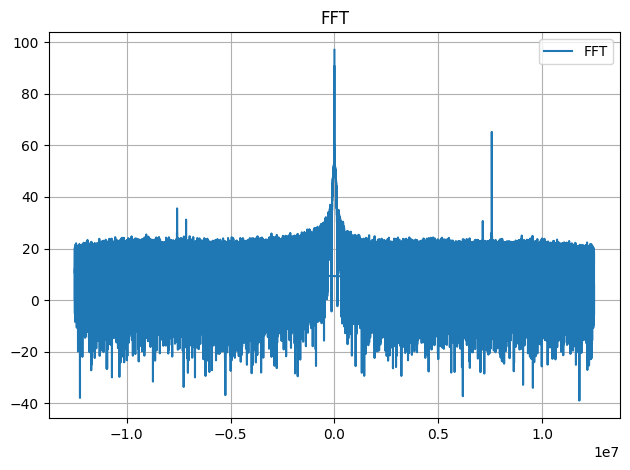

In [2]:
file_path = 'rx_test.bin'


# Read the binary file
with open(file_path, 'rb') as file:
    # Read the data into a numpy array
    # The dtype should match the type of data in the file (double = float64)
    data = np.fromfile(file, dtype=np.float64)

# Reshape or process the data if needed
# Here we assume data was written as 2 doubles per sample
num_new_samples = int(len(data)/2)
data = data.reshape((num_new_samples, 2))
#data = data[30000:32000]

# Create complex numbers from the real and imaginary parts
complex_data = data[:, 0] + 1j * data[:, 1]


fs = 25e6
N = len(complex_data)


#fft_data = np.fft.fftshift(np.fft.fft(complex_data))
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude)


max_freq_desired = 50e6
index = int(round(max_freq_desired*N/fs))



#fft_freq_axis = fft_freq_axis[0:index]
#magnitude_db = magnitude_db[0:index]


# Plotting fft
fig, axs = plt.subplots()
axs.plot(fft_freq_axis, magnitude_db, label='FFT')
axs.set_title('FFT')
axs.legend()
axs.grid(True)
plt.tight_layout()
plt.show()

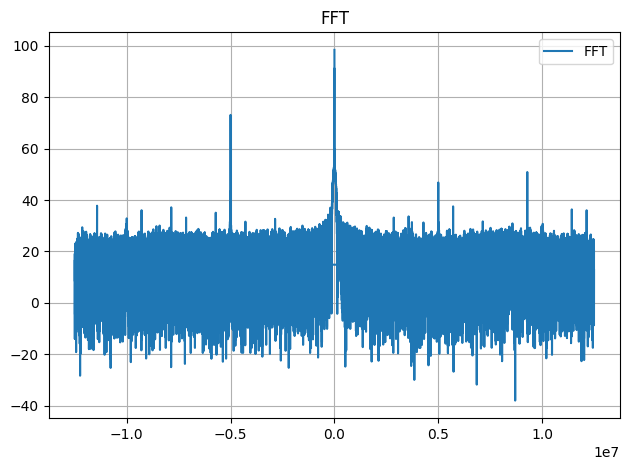

In [6]:
file_path = 'loopback_test.bin'


# Read the binary file
with open(file_path, 'rb') as file:
    # Read the data into a numpy array
    # The dtype should match the type of data in the file (double = float64)
    data = np.fromfile(file, dtype=np.float64)

# Reshape or process the data if needed
# Here we assume data was written as 2 doubles per sample
num_new_samples = int(len(data)/2)
data = data.reshape((num_new_samples, 2))
#data = data[30000:32000]

# Create complex numbers from the real and imaginary parts
complex_data = data[:, 0] + 1j * data[:, 1]


fs = 25e6
N = len(complex_data)


#fft_data = np.fft.fftshift(np.fft.fft(complex_data))
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude)


max_freq_desired = 50e6
index = int(round(max_freq_desired*N/fs))



#fft_freq_axis = fft_freq_axis[0:index]
#magnitude_db = magnitude_db[0:index]


# Plotting fft
fig, axs = plt.subplots()
axs.plot(fft_freq_axis, magnitude_db, label='FFT')
axs.set_title('FFT')
axs.legend()
axs.grid(True)
plt.tight_layout()
plt.show()

In [3]:
# write to csv for TX

# params
# relative to TX centre freq
signalLength = 500000
startFrequency = 0 # IQ stuff
endFrequency = 2e6
sampleRate = 50e6

result = []

for i in range(signalLength):
    t = i / sampleRate
    frequency = startFrequency + (endFrequency - startFrequency) * i / signalLength
    phase = 2.0 * np.pi * frequency * t
    sample = 0.5 * np.cos(phase) + 0j  # 0j denotes a complex number with zero imaginary part
    result.append(sample)

# Write to CSV file
with open('sweep.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for sample in result:
        csvwriter.writerow([sample.real, sample.imag])



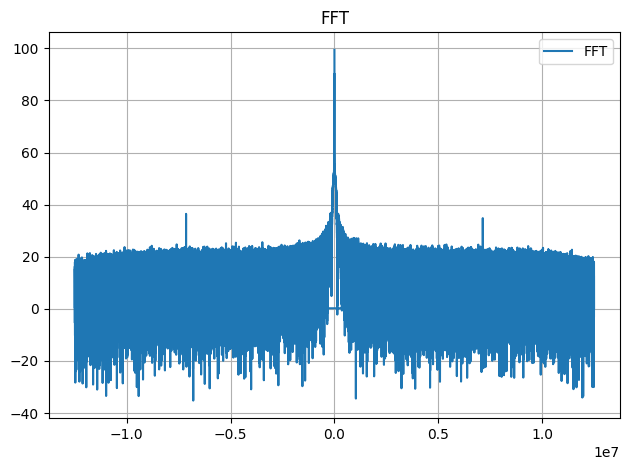

In [4]:
file_path = 'loopback_from_file_test.bin'


# Read the binary file
with open(file_path, 'rb') as file:
    # Read the data into a numpy array
    # The dtype should match the type of data in the file (double = float64)
    data = np.fromfile(file, dtype=np.float64)

# Reshape or process the data if needed
# Here we assume data was written as 2 doubles per sample
num_new_samples = int(len(data)/2)
data = data.reshape((num_new_samples, 2))
#data = data[30000:32000]

# Create complex numbers from the real and imaginary parts
complex_data = data[:, 0] + 1j * data[:, 1]


fs = 25e6
N = len(complex_data)


#fft_data = np.fft.fftshift(np.fft.fft(complex_data))
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude)



# Plotting fft
fig, axs = plt.subplots()
axs.plot(fft_freq_axis, magnitude_db, label='FFT')
axs.set_title('FFT')
axs.legend()
axs.grid(True)
plt.tight_layout()
plt.show()